In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table
# from scipy.spatial import distance
# from scipy import spatial
# from scipy.spatial import KDTree
import time
import matplotlib.path as mpltPath
from pandas import DataFrame, read_csv
import pandas as pd 
from mpl_toolkits.mplot3d import Axes3D
import copy

In [3]:
file = r'Gaia_plx7_dr2.csv'
df = pd.read_csv(file)
df2 = df.columns.get_values()
df2.tolist()
#print('Succesfully Read in the Data')

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (96,122,130) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['Unnamed: 0',
 'solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source'

In [4]:
Gmag = df["phot_g_mean_mag"].values
GBmag = df["phot_bp_mean_mag"].values
GRmag = df["phot_rp_mean_mag"].values
# 2MASS bands
Jmag = df["j_m"].values
Hmag = df["h_m"].values
Kmag = df["ks_m"].values
J_unc = df['j_msigcom'].values
H_unc = df['h_msigcom'].values
K_unc = df['ks_msigcom'].values
# Other Important Data
plx = df["parallax"].values
Dist = 1000./plx
K_er = df["ks_msigcom"].values
J_er = df['j_msigcom'].values
H_er = df['h_msigcom'].values
G_flux = df["phot_g_mean_flux"].values
G_flux_er = df["phot_g_mean_flux_error"].values
GB_flux = df['phot_bp_mean_flux'].values
GB_flux_er = df['phot_bp_mean_flux_error'].values
GR_flux = df['phot_rp_mean_flux'].values
GR_flux_er = df['phot_rp_mean_flux_error'].values

In [5]:
def ColorClassification(Gmags,Kmags,colors):    
    #assign the stars into different categories based on G-K
    
    #Variables Read In
    #Gmags: numpy array of absolute magnitudes in G
    #Kmags: numpy array of absolute magnitudes in K
    #colors: list or array of values of G-K in increasing order
    
    #Variables Returned
    #color: numpy array that indicates the category of G-K that each star belongs to
    
    #caclculate the values of G-K for all stars
    
    G_K = Gmags-Kmags
    
    #create array to hold the G-K color categories 
    color = np.ones(len(G_K))*1000
    
    #compare the value of G-K for each star to the categories and assign a corresponding
    #value for the category in the color array
    for i in range(len(colors)):
        for j in range(len(G_K)):
            if (i == 0):
                if (G_K[j] <= colors[i]):
                    color[j] = colors[i]
            elif(G_K[j] <= colors[i] and G_K[j] > colors[i-1]):
                color[j] = colors[i]
    return color

In [6]:
def CreateTemplates(color,colors,Gmags,Kmags,GB_mags=[999],GR_mags=[999],J_mags=[999],H_mags=[999],umags=[999],gmags=[999],rmags=[999],imags=[999],zmags=[999]):
    #For each category of G-K, a template is created of the absolute magnitudes of the stars and their color indices 
    #calculated with bands of different magnitudes
    # ** Gmags and Kmags is REQUIRED ** 
    #Variables Read In:
    #color: numpy array that indicates the category of G-K that each star belongs to
    #colors: list or array of values of G-K in increasing order
    #GBmags: numpy array of absolute magnitudes in GB
    #GRmags: numpy array of absolute magnitudes in GR
    #Gmags: numpy array of absolute magnitudes in G
    #Jmags: numpy array of absolute magnitudes in J
    #Hmags: numpy array of absolute magnitudes in H 
    #Kmags: numpy array of absolute magnitudes in K
    #umags: numpy array of absolute magnitudes in u
    #gmags: numpy array of absolute magnitudes in g
    #rmags: numpy array of absolute magnitudes in r
    #imags: numpy array of absolute magnitudes in i
    #zmags: numpy array of absolute magnitudes in z
    
    #Variables Returned: 
    #stars: array of the number of stars in each category of G-K
    #color_mags: array of the color indices at each wavelength for all of the categories of G-K
    #color_std: array of the standard deviation of color indices at each wavelength for all of the categories of G-K
    #color_std_err: array of the standard deviation error of thecolor indices at each wavelength for all of the categories of G-K
    #abs_color_mags: array of the average absolute magnitudes in each band for all of the categories of G-K
    #abs_color_std: array of the standard deviation of absolute magnitudes in each band for all of the categories of G-K
    #abs_color_std_err: array of the standard deviation error of absolute magnitudes in each band for all categores of G-K
    
    if(len(GB_mags) < 2):
        GB_mags = np.ones(len(Gmags))*np.nan
    if(len(GR_mags) < 2):
        GR_mags = np.ones(len(Gmags))*np.nan
    if(len(J_mags) < 2):
        J_mags = np.ones(len(Gmags))*np.nan
    if(len(H_mags) < 2):
        H_mags = np.ones(len(Gmags))*np.nan
    if(len(umags) < 2):
        umags = np.ones(len(Gmags))*np.nan
    if(len(gmags) < 2):
        gmags = np.ones(len(Gmags))*np.nan
    if(len(zmags) < 2):
        zmags = np.ones(len(Gmags))*np.nan
    if(len(imags) < 2):
        imags = np.ones(len(Gmags))*np.nan
    if(len(rmags) < 2):
        rmags = np.ones(len(Gmags))*np.nan
    
    
    #Calculate the values of G-K for each star
    G_K = Gmags-Kmags
    
    #create array to hold the number of stars in each template: 
    stars = np.array([])
    
    for c in colors:
        #create array of values for color indices and absolute magnitudes
        G_GB_array = np.array([])
        G_GR_array = np.array([])
        G_J_array = np.array([])
        G_H_array = np.array([])
        G_K_array = np.array([])
        G_u_array = np.array([])
        G_g_array = np.array([])
        G_r_array = np.array([])
        G_i_array = np.array([])
        G_z_array = np.array([])
        GB = np.array([])
        GR = np.array([])
        G = np.array([])
        J = np.array([])
        H = np.array([])
        K = np.array([])
        u = np.array([])
        g = np.array([])
        r = np.array([])
        i_m = np.array([])
        z = np.array([])
        star_count = 0
        #fill arrays with values if the values are part of the color category
        for i in range(len(Gmags)):
            if (color[i] == c):
                
                G_GB_array = np.append(G_GB_array,Gmags[i]-GB_mags[i])
                G_GR_array = np.append(G_GR_array,Gmags[i]-GR_mags[i])
                G_J_array = np.append(G_J_array,Gmags[i]-J_mags[i])
                G_H_array = np.append(G_H_array,Gmags[i]-H_mags[i])
                G_K_array = np.append(G_K_array,Gmags[i]-Kmags[i])
                G_u_array = np.append(G_u_array,Gmags[i]-umags[i])
                G_g_array = np.append(G_g_array,Gmags[i]-gmags[i])
                G_r_array = np.append(G_r_array,Gmags[i]-rmags[i])
                G_i_array = np.append(G_i_array,Gmags[i]-umags[i])
                G_z_array = np.append(G_z_array,Gmags[i]-zmags[i])
                GB = np.append(GB,GB_mags[i])
                GR = np.append(GR,GR_mags[i])
                G = np.append(G,Gmags[i])
                J = np.append(J,J_mags[i])
                H = np.append(H,H_mags[i])
                K = np.append(K,Kmags[i])
                u = np.append(u,umags[i])
                g = np.append(g,umags[i])
                r = np.append(r,rmags[i])
                i_m = np.append(i_m,imags[i])
                z = np.append(z,zmags[i])
                star_count = star_count +1
        #number of stars per color
        stars = np.append(stars,star_count)
        #relative SED
        mag_array = [np.nanmean(G_u_array),np.nanmean(G_g_array), np.nanmean(G_GB_array),\
                     np.nanmean(G_r_array),np.nanmean(G_i_array), np.nanmean(G_GR_array), \
                     np.nanmean(G_z_array),np.nanmean(G_J_array), np.nanmean(G_H_array), \
                     np.nanmean(G_K_array)]
        std_array = [np.nanstd(G_u_array),np.nanstd(G_g_array), np.nanstd(G_GB_array),\
                     np.nanstd(G_r_array),np.nanstd(G_i_array), np.nanstd(G_GR_array), \
                     np.nanstd(G_z_array),np.nanstd(G_J_array), np.nanstd(G_H_array), \
                     np.nanstd(G_K_array)]
        #absolute SED
        mag_array2 = [np.nanmean(u), np.nanmean(g), np.nanmean(GB), \
                      np.nanmean(r), np.nanmean(G), np.nanmean(i), \
                      np.nanmean(GR), np.nanmean(z), np.nanmean(J), \
                      np.nanmean(H), np.nanmean(K)]
        std_array2 = [np.nanstd(u), np.nanstd(g), np.nanstd(GB), \
                      np.nanstd(r), np.nanstd(G), np.nanstd(i_m), \
                      np.nanstd(GR), np.nanstd(z), np.nanstd(J), \
                      np.nanstd(H), np.nanstd(K)]
        #calculate standard deviation error
        val = np.sqrt(len(G_u_array))
        std_array3 = std_array/val
        val2 = np.sqrt(len(u))
        std_array4 = std_array2/val2
        #stack SEDs
        if (c == colors[0]):
            
            color_mags = np.array(mag_array)
            color_std = np.array(std_array)
            color_std_err = np.array(std_array3)
            abs_color_mags = np.array(mag_array2)
            abs_color_std = np.array(std_array2)
            abs_color_std_err = np.array(std_array4)
        else:
            #print(len(color_mags),len(mag_array))
            color_mags = np.vstack((color_mags,mag_array))
            color_std = np.vstack((color_std,std_array))
            color_std_err = np.vstack((color_std_err,std_array3))
            #print('\n',len(abs_color_mags),len(mag_array2))
            abs_color_mags = np.vstack((abs_color_mags, mag_array2))
            abs_color_std = np.vstack((abs_color_mags, std_array2))
            abs_color_std_err = np.vstack((abs_color_std_err,std_array4))
            #A[~np.isnan(A)])
    #print((color_mags))
#     color_mags = color_mags[~np.isnan(color_mags)]
#     #print(len(color_mags))
#     color_std = color_std[~np.isnan(color_std)]
#     color_std_err = color_std_err[~np.isnan(color_std_err)]
#     abs_color_mags = abs_color_mags[~np.isnan(abs_color_mags)]
#     abs_color_std = abs_color_std[~np.isnan(abs_color_std)]
#     abs_color_std_err = abs_color_std_err[~np.isnan(abs_color_std_err)]
#     color_mags = np.reshape(color_mags, (-1, 10))
#     color_std = np.reshape(color_std, (-1, 10))
#     color_std_err = np.reshape(color_std_err, (-1, 10))
#     print(color_mags,'\n',abs_color_mags)
#     abs_color_mags = np.reshape(abs_color_mags, (-1, 11))
#     abs_color_std = np.reshape(abs_color_std, (-1, 11))
#     abs_color_std_err = np.reshape(abs_color_std_err, (-1, 11))
            
    return stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err

In [756]:
print(Gmag[0],'\n') 

print(G_flux[0],'\n')
#ratio_val = 

mag = 2.5*np.log10(1.884950e10/G_flux[0])
print(mag,Gmag[0])
print(2.5*16)

16.30409812927246 

5671.621970286633 

16.303981396156427 16.30409812927246
40.0


In [7]:
Gmags = Gmag - 5 * np.log10(Dist) + 5
GK = Gmag - Kmag
br_Gmag = []
br_Gflux = []
br_Gflux_er = []
br_GBmag = []
br_GBflux = []
br_GBflux_er = []
br_GRmag = []
br_GRflux = []
br_GRflux_er = []
br_Jmag = []
br_Hmag = []
br_Kmag = []
br_GK = []
br_G = []
J_unc_br = []
H_unc_br = []
K_unc_br = []
for i in range(len(Gmags)):
    if(Gmags[i] < 10 and GK[i] >= -0.45 and GK[i] <= 3.0):
    #if(SNR[i] > 50):
        br_Gmag.append(Gmag[i])
        br_GBmag.append(GBmag[i])
        br_GRmag.append(GRmag[i])
        br_Jmag.append(Jmag[i])
        br_Hmag.append(Hmag[i])
        br_Kmag.append(Kmag[i])
        br_GK.append(GK[i])
        br_G.append(Gmags[i])
        br_Gflux.append(G_flux[i])
        br_Gflux_er.append(G_flux_er[i])
        br_GBflux.append(GB_flux[i])
        br_GBflux_er.append(GB_flux_er[i])
        br_GRflux.append(GR_flux[i])
        br_GRflux_er.append(GR_flux_er[i])
        J_unc_br.append(J_unc[i])
        H_unc_br.append(H_unc[i])
        K_unc_br.append(K_unc[i])
    
br_Gmag = np.array(br_Gmag)
br_GBmag = np.array(br_GBmag)
br_GRmag = np.array(br_GRmag)
br_Jmag = np.array(br_Jmag)
br_Hmag = np.array(br_Hmag)
br_Kmag = np.array(br_Kmag)
br_Gflux = np.array(br_Gflux)
br_Gflux_er = np.array(br_Gflux_er)
br_GBflux = np.array(br_GBflux)
br_GBflux_er = np.array(br_GBflux_er)
br_GRflux = np.array(br_GRflux)
br_GRflux_er = np.array(br_GRflux_er)
br_GK = np.array(br_GK)
br_G = np.array(br_G)
all_BrightStars = np.transpose([br_Gmag,br_GBmag,br_GRmag,br_Jmag,br_Hmag,br_Kmag])
print('Length of Br_Mags:',len(br_Gmag))

dm_G = []
dm_Gmag = []
dm_GBmag = []
dm_GRmag = []
dm_Jmag = []
dm_Hmag = []
dm_Kmag = []
dm_GK = []
dm_Gflux = []
dm_Gflux_er = []
dm_GBflux = []
dm_GBflux_er = []
dm_GRflux = []
dm_GRflux_er = []
J_unc_dm = []
H_unc_dm = []
K_unc_dm = []
for i in range(len(Gmags)):
    if(Gmags[i] > 10 and GK[i] >= -0.45 and GK[i] <= 3.0):
        dm_Gmag.append(Gmag[i])
        dm_GBmag.append(GBmag[i])
        dm_GRmag.append(GRmag[i])
        dm_Jmag.append(Jmag[i])
        dm_Hmag.append(Hmag[i])
        dm_Kmag.append(Kmag[i])
        dm_GK.append(GK[i])
        dm_G.append(Gmags[i])
        dm_Gflux.append(G_flux[i])
        dm_Gflux_er.append(G_flux_er[i])
        dm_GBflux.append(GB_flux[i])
        dm_GBflux_er.append(GB_flux_er[i])
        dm_GRflux.append(GR_flux[i])
        dm_GRflux_er.append(GR_flux_er[i])
        J_unc_dm.append(J_unc[i])
        H_unc_dm.append(H_unc[i])
        K_unc_dm.append(K_unc[i])

dm_Gflux = np.array(dm_Gflux)
dm_Gflux_er = np.array(dm_Gflux_er)
dm_GBflux = np.array(dm_GBflux)
dm_GBflux_er = np.array(dm_GBflux_er)
dm_GRflux = np.array(dm_GRflux)
dm_GRflux_er = np.array(dm_GRflux_er)
dm_Gmag = np.array(dm_Gmag)
dm_GBmag = np.array(dm_GBmag)
dm_GRmag = np.array(dm_GRmag)
dm_Jmag = np.array(dm_Jmag)
dm_Hmag = np.array(dm_Hmag)
dm_Kmag = np.array(dm_Kmag)
dm_GK = np.array(dm_GK)
dm_G = np.array(dm_G)
all_dimStars = np.transpose([dm_Gmag,dm_GBmag,dm_GRmag,dm_Jmag,dm_Hmag,dm_Kmag])
print('Length of dm_Mags:',len(dm_Gmag))

Length of Br_Mags: 169931
Length of dm_Mags: 25988


In [245]:
BrightStars = np.transpose([br_Gmag,br_GBmag,br_GRmag,br_Jmag,br_Hmag,br_Kmag])
print(BrightStars[0])

FaintS

[10.02853012 10.37783909  9.54774475  8.99300003  8.68599987  8.65100002]


In [7]:
def StarFitting(starBands,color_mags,color_std):
    new_starBands = []
    for i in range(len(starBands)):
        if(i == 0):
            G = starBands[i]
        else:
            G_X = G - starBands[i]
            new_starBands.append(G_X)
    
    template_bands = []
    template_err = []
    for i in range(len(color_mags)):
        cm = color_mags[i,:]
        cm = cm[~np.isnan(cm)]
        cs = color_std[i,:]
        cs = cs[~np.isnan(cs)]
        template_bands.append(cm)
        template_err.append(cs)
    template_bands = np.array(template_bands)
    template_err = np.array(template_err)
    
    Chi2_vals = []
    for i in range(len(template_bands)):
        Chi2 = 0
        for j in range(len(new_starBands)):
            Chi2 = Chi2 + ((template_bands[i,j] - new_starBands[j])**2/(template_err[i,j])**2)
        Chi2 = Chi2/(len(new_starBands)-1)  # EDITED THIS LINE JUNE 7TH. GOT RID OF THE -1
        Chi2_vals.append(Chi2)
    Chi2_vals = np.array(Chi2_vals)
    
    red_Chi2 = []
    for i in range(len(Chi2_vals)):
        if(Chi2_vals[i] == np.min(Chi2_vals)):
            chi_val = Chi2_vals[i]
            
            red_Chi2.append(chi_val)
            best_fit = i
#             print('The best Template is '+ str((best_fit+1)) +' out of '+str(len(template_bands))+ ' templates')
#             print('Or ' + str(best_fit) + ' out of ' + str((len(template_bands)-1)))
    #print(best_fit)
    return best_fit, new_starBands, red_Chi2

In [758]:
np.log(10)

2.302585092994046

In [876]:
Gmags = Gmag - 5 * np.log10(Dist) + 5
#Gmags = Gmag - 5 * np.log10(Dist) + 5
m = np.random.randint(1,len(Gmags))
mag1 = Gmag[m]
#mag2 = Gmag[3]

flux1 = G_flux[m]
flux1_er = G_flux_er[m]

n = np.random.randint(1,len(Gmags))

flux2 = G_flux[n]
flux2_er = G_flux_er[n]
def MagError(flux2,flux2_er,min_val):
    
    #Mag = 2.5*np.log10(flux1/flux2) + KnownMag
    Mag_er = np.sqrt((2.5/np.log(10))**2*(flux2_er/flux2)**2)
    #Mag_er = np.sqrt(((2.5/(np.log(10)*flux1))*flux1_er)**2 + ((-2.5/(np.log(10)*flux2))*flux2_er)**2)
    if(Mag_er < min_val):
        Mag_er = min_val
    return Mag_er


if(str(flux1) != 'nan' and str(flux2) != 'nan' and str(flux1_er) != 'nan' and str(flux2_er) != 'nan' and str(mag1) != 'nan'):
    Mag_er = MagError(flux2,flux2_er)
    #print(mag1)
    #print(flux1,'\n')
    
    print(Mag_er)
    #print(Gmags[n])
    #print(abs(Mag - Gmag[n]))
else:
    print('Error')


0.0031622776601683794


In [8]:
def MagError(flux2,flux2_er,min_val):
    
    #Mag = 2.5*np.log10(flux1/flux2) + KnownMag
    Mag_er = np.sqrt((2.5/np.log(10)**2)*(flux2_er/flux2)**2)
    #Mag_er = np.sqrt(((2.5/(np.log(10)*flux1))*flux1_er)**2 + ((-2.5/(np.log(10)*flux2))*flux2_er)**2)
    if(Mag_er < min_val):
        Mag_er = min_val
    return Mag_er

In [324]:
color[0]

-1.0

In [15]:
G_unc_dm = []
count = 0

for i in range(0,len(dm_Gmag)):
    #n = np.random.randint(1,len(br_Gmag))
#     mag = br_Gmag[0]
#     flux1 = br_Gflux[0]
#     flux1_er = br_Gflux_er[0]
    flux = dm_GBflux[i]
    flux_er = dm_GBflux_er[i]
    if(str(flux) != 'nan' and str(flux_er) != 'nan'):
        Mag_er = MagError(flux,flux_er,0.001)
#     if(Mag_er < 10**(-2.5)):
#         Mag_er == 10**(-2.5)
    G_unc_dm.append(Mag_er)

G_unc_dm = np.array(G_unc_dm)
# plt.hist(GB_unc_br,500)
# plt.hist(G_unc_dm,200,alpha=0.6)
# plt.xlim([0,.03])
# plt.show()
# print(np.median(GB_unc_br))
# print(np.median(G_unc_br))
# print(np.mean(GB_unc_br))   

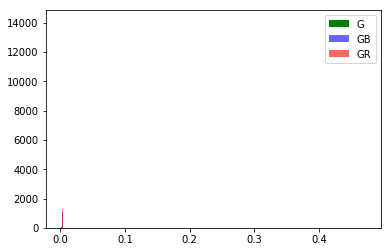

Mean Star Uncertainty in G: 0.0011225877451790398
Mean Star Uncertainty in GB: 0.0035671308301309674
Mean Star Uncertainty in GR: 0.0034476163426431852
Median Star Uncertainty in G: 0.001
Median Star Uncertainty in GB: 0.0031622776601683794
Median Star Uncertainty in GR: 0.0031622776601683794


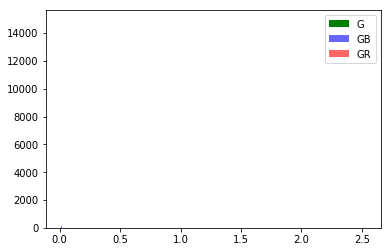

Mean Star Uncertainty in G: 0.010063616474795886
Mean Star Uncertainty in GB: 0.016296615846763163
Mean Star Uncertainty in GR: 0.010664253084964161
Median Star Uncertainty in G: 0.01
Median Star Uncertainty in GB: 0.01
Median Star Uncertainty in GR: 0.01
0.04404879530312566


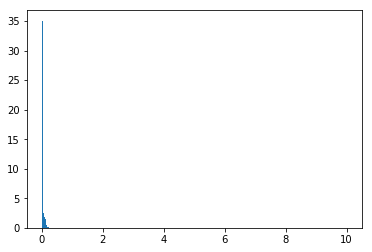

0.04404879530312566


In [159]:
plt.hist(G_unc_br,500,label='G',color='green',normed=True)
plt.hist(GB_unc_br,500,alpha=0.6,label='GB',color='blue',normed=True)
plt.hist(GR_unc_br,500,alpha=0.6,label='GR',color='red',normed=True)
#plt.xlim([0,.006])
plt.legend()
plt.show()


print('Mean Star Uncertainty in G:',np.mean(G_unc_br)) 
print('Mean Star Uncertainty in GB:',np.mean(GB_unc_br))
print('Mean Star Uncertainty in GR:',np.mean(GR_unc_br))
print('Median Star Uncertainty in G:',np.median(G_unc_br))
print('Median Star Uncertainty in GB:',np.median(GB_unc_br))
print('Median Star Uncertainty in GR:',np.median(GR_unc_br))

plt.hist(G_unc_dm,500,label='G',color='green',normed=True)
plt.hist(GB_unc_dm,500,alpha=0.6,label='GB',color='blue',normed=True)
plt.hist(GR_unc_dm,500,alpha=0.6,label='GR',color='red',normed=True)
#plt.xlim([0,.02])
plt.legend()
plt.show()

print('Mean Star Uncertainty in G:',np.mean(G_unc_dm)) 
print('Mean Star Uncertainty in GB:',np.mean(GB_unc_dm))
print('Mean Star Uncertainty in GR:',np.mean(GR_unc_dm))
print('Median Star Uncertainty in G:',np.median(G_unc_dm))
print('Median Star Uncertainty in GB:',np.median(GB_unc_dm))
print('Median Star Uncertainty in GR:',np.median(GR_unc_dm))



print(np.nanmean(J_unc))
J_err = copy.copy(J_unc)
J_err = J_err[~np.isnan(J_err)]
plt.hist(J_err,500,normed=True)
plt.show()
print(np.mean(J_err))

In [875]:
print(np.min(GR_unc_dm))
10**(-2.5)

0.001


0.0031622776601683794

In [306]:
print(len(G_unc_br),len(GB_unc_br),len(GR_unc_br),len(J_unc_br),len(H_unc_br),len(K_unc_br))

296527 296527 296527 296527 296527 296527


In [275]:
starBand

array([ 9.99699593, 10.32921124,  9.53026867,  8.9829998 ,  8.6590004 ,
        8.62300014])

In [118]:
def StarFitQuad(starBands,color_mags,starError,color_std):
    new_starBands = []
    for i in range(len(starBands)):
        if(i == 0):
            G = starBands[i]
        else:
            G_X = G - starBands[i]
            new_starBands.append(G_X)
    
    template_bands = []
    template_err = []
    for i in range(len(color_mags)):
        cm = color_mags[i,:]
        cm = cm[~np.isnan(cm)]
        cs = color_std[i,:]
        cs = cs[~np.isnan(cs)]
        template_bands.append(cm)
        template_err.append(cs)
    template_bands = np.array(template_bands)
    template_err = np.array(template_err)
    
    newStarError = []
    for i in range(len(starError)):
        if(i == 0):
            sigmaG = starError[i]
        else:
            sigma = starError[i]
            newStarError.append(np.sqrt(sigmaG**2+sigma**2))
    newStarError = np.array(newStarError)
    Chi2_vals = []
    
    QuadError = []
    for i in range(len(template_err)):
        QuadError.append(np.sqrt(newStarError**2 + template_err[i]**2))
    QuadError = np.array(QuadError)
#     print(starError)
#     print(newStarError)
#     print(template_err[0])
#     print(QuadError[0])
    
    for i in range(len(template_bands)):
        #print(template_bands[i])
        #print(new_starBands)
        #Chi2 = ((template_bands[i] - new_starBands)**2/(QuadError[i])**2)
        #Chi2 = np.sum(Chi2)
        Chi2 = 0
        for j in range(len(new_starBands)):
            Chi2 = Chi2 + ((template_bands[i,j] - new_starBands[j])**2/(QuadError[i,j])**2)
        Chi2 = Chi2/(len(new_starBands))  # EDITED THIS LINE JUNE 7TH. GOT RID OF THE -1
        Chi2_vals.append(Chi2)
    #print(len(new_starBands))
    Chi2_vals = np.array(Chi2_vals)
    #print(Chi2_vals)
    red_Chi2 = []
    for i in range(len(Chi2_vals)):
        if(Chi2_vals[i] == np.min(Chi2_vals)):
            chi_val = Chi2_vals[i]
            
            #red_Chi2.append(chi_val)
            best_fit = i
            
#             print('The best Template is '+ str((best_fit+1)) +' out of '+str(len(template_bands))+ ' templates')
#             print('Or ' + str(best_fit) + ' out of ' + str((len(template_bands)-1)))
    #print(best_fit)
    return best_fit, new_starBands, newStarError, chi_val, Chi2_vals

In [16]:
def StarFit(starBands,color_mags,star_err):
    new_starBands = []
    for i in range(len(starBands)):
        if(i == 0):
            G = starBands[i]
        else:
            G_X = G - starBands[i]
            new_starBands.append(G_X)
    
    template_bands = []
    for i in range(len(color_mags)):
        cm = color_mags[i,:]
        cm = cm[~np.isnan(cm)]
        template_bands.append(cm)
    template_bands = np.array(template_bands)
    
    newStar_err = []
    for i in range(len(star_err)):
        if(i == 0):
            sigmaG = star_err[i]
        else:
            sigma = star_err[i]
            newStar_err.append(np.sqrt(sigmaG**2+sigma**2))
    newStar_err = np.array(newStar_err)
    Chi2_vals = []
    for i in range(len(template_bands)):
        #print(template_bands[i])
        #print(new_starBands)
        Chi2 = ((template_bands[i] - new_starBands)**2/(newStar_err)**2)
        Chi2 = np.sum(Chi2)
#         Chi2 = 0
#         for j in range(len(new_starBands)):
#             Chi2 = Chi2 + ((template_bands[i,j] - new_starBands[j])**2/(star_err[j])**2)
        Chi2 = Chi2/(len(new_starBands))  # EDITED THIS LINE JUNE 7TH. GOT RID OF THE -1
        Chi2_vals.append(Chi2)
    Chi2_vals = np.array(Chi2_vals)
    
    red_Chi2 = []
    for i in range(len(Chi2_vals)):
        if(Chi2_vals[i] == np.min(Chi2_vals)):
            chi_val = Chi2_vals[i]
            
            #red_Chi2.append(chi_val)
            best_fit = i
            
#             print('The best Template is '+ str((best_fit+1)) +' out of '+str(len(template_bands))+ ' templates')
#             print('Or ' + str(best_fit) + ' out of ' + str((len(template_bands)-1)))
    #print(best_fit)
    return best_fit, new_starBands, newStar_err, chi_val, Chi2_vals

In [17]:
colors = np.arange(-0.45,3,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS/TEMPLATES

# BRIGHT STARS
color_br = ColorClassification(br_Gmag,br_Kmag,colors)

stars_br,color_mags_br,color_std_br,color_std_err_br,abs_color_mags_br,abs_color_std_br,abs_color_std_err_br = \
CreateTemplates(color_br,colors,Gmags=br_Gmag,Kmags=br_Kmag,GB_mags=br_GBmag,GR_mags=br_GRmag,J_mags=br_Jmag,H_mags=br_Hmag)

# DIM STARS
color_dm = ColorClassification(dm_Gmag,dm_Kmag,colors)

stars_dm,color_mags_dm,color_std_dm,color_std_err_dm,abs_color_mags_dm,abs_color_std_dm,abs_color_std_err_dm = \
CreateTemplates(color_dm,colors,dm_Gmag,dm_Kmag,GB_mags=dm_GBmag,GR_mags=dm_GRmag,J_mags=dm_Jmag,H_mags=dm_Hmag)

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


In [611]:
star_err = np.transpose([G_unc_br,GB_unc_br,GR_unc_br,J_unc_br,H_unc_br,K_unc_br])
idx = np.random.randint(1,len(br_Gmag))
print(star_err[idx])

print(color_mags_br[0])
print(colors[0])

[0.0007621  0.0039265  0.00331419 0.022      0.023      0.023     ]
[nan nan nan nan nan nan nan nan nan nan]
1.0


In [322]:
print(color_mags_br[5])

[        nan         nan -0.73090595         nan         nan -0.34034348
         nan -0.71573102 -0.85998094 -0.95523083]


[        nan         nan  0.0104925          nan         nan -0.1461253
         nan -0.45018361 -0.39085025 -0.43251691]

Reduced X^2 for Bright Template Fit: 2.05423047201
Reduced X^2 for Faint Template Fit: 379.28433668


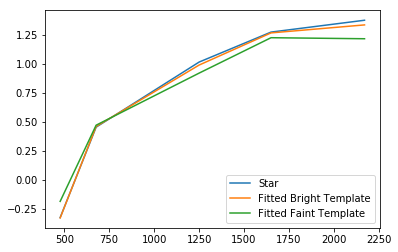

In [27]:
#print(color_mags_br[0])
mags = copy.copy(color_mags_br)
mags = mags[1:len(mags)]
mags_dm = copy.copy(color_mags_dm)
mags_dm = mags_dm[1:len(mags_dm)]
print(mags[0])
star_err = np.transpose([G_unc_br,GB_unc_br,GR_unc_br,J_unc_br,H_unc_br,K_unc_br])
idx = np.random.randint(1,len(br_Gmag))
starBand = all_BrightStars[idx]
starBand = np.array(starBand)
starBand = starBand[~np.isnan(starBand)]
starError = star_err[idx]
starError = starError[~np.isnan(starError)]
#print(starError)
if(len(starBand) == len(all_BrightStars[idx]) and len(starError) == len(star_err[idx])):
    
    fit, newBands, newStar_err, chi2, chi2_vals1 = StarFit(starBand,mags,starError)
    fit2, newBands, newStar_err2, chi2_2, chi2_vals2 = StarFit(starBand,mags_dm,starError)
#print(newStar_err)
wvl = [477,677,1250,1650,2170]
print('\nReduced X^2 for Bright Template Fit:', chi2)
print('Reduced X^2 for Faint Template Fit:', chi2_2)
mag2 = copy.copy(mags[fit])
mag2 = mag2[~np.isnan(mag2)]
mag3 = copy.copy(mags_dm[fit2])
mag3 = mag3[~np.isnan(mag3)]
plt.plot(wvl,newBands,label='Star')
plt.plot(wvl,mag2,label='Fitted Bright Template')
plt.plot(wvl,mag3,label='Fitted Faint Template')
plt.legend()
plt.show()


# first10Chi2 = []
# while(len(first10Chi2) <= 10):
#     for i in range(len(chi2_vals1)):
#         if(chi2_vals1[i] == np.nanmin(chi2_vals1)):
#             ID = i
#             first10Chi2.append(chi2_vals1[i])
#     chi2_vals1[ID] = np.nan
        
# #print('Reduced X^2 Value for StarFitting:', chi2)
# first10Chi2 = np.array(first10Chi2)
# t['1'] = first10Chi2
# print(first10Chi2)

In [285]:
print(new_starBands)

NameError: name 'new_starBands' is not defined

In [396]:
print(colors[55])

-0.4499999999999995


In [1065]:
t['1']

1.528557226968787
9.735772645210192
15.653264943093955
37.753185337448656
52.863990319337404
90.45637569476258
118.10834926346759
152.89398032289196
202.55347928448518
223.64331369408114
324.1721859478239


[0.00637659 0.01140068 0.00755133 0.091      0.13       0.183     ]
[0.01306279 0.0098835  0.09122314 0.13015629 0.18311106]

Reduced X^2 for Bright Template Fit: 38.6420508800395
Reduced X^2 for Faint Template Fit: 32.92842282048118


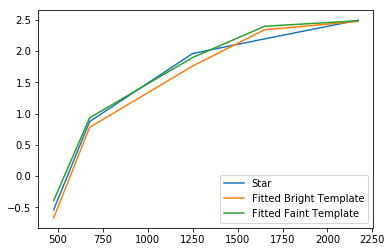

In [447]:
mags = copy.copy(color_mags_br)
mags = mags[55:len(mags)]
mags_dm = copy.copy(color_mags_dm)
mags_dm = mags_dm[55:len(mags_dm)]
star_err_dm = np.transpose([G_unc_dm,GB_unc_dm,GR_unc_dm,J_unc_dm,H_unc_dm,K_unc_dm])
idx = np.random.randint(1,len(dm_Gmag))
starBand = all_dimStars[idx]
starBand = np.array(starBand)
starBand = starBand[~np.isnan(starBand)]
starError = star_err_dm[idx]
starError = starError[~np.isnan(starError)]
print(starError)
if(len(starBand) == len(all_dimStars[idx]) and len(starError) == len(star_err_dm[idx])):
    
    fit, newBands, newStar_err, chi2, chi2_vals1 = StarFit(starBand,mags,starError)
    fit2, newBands, newStar_err2, chi2_2, chi2_vals2 = StarFit(starBand,mags_dm,starError)
print(newStar_err)
wvl = [477,677,1250,1650,2170]
print('\nReduced X^2 for Bright Template Fit:', chi2)
print('Reduced X^2 for Faint Template Fit:', chi2_2)
mag2 = copy.copy(mags[fit])
mag2 = mag2[~np.isnan(mag2)]
mag3 = copy.copy(mags_dm[fit2])
mag3 = mag3[~np.isnan(mag3)]
plt.plot(wvl,newBands,label='Star')
plt.plot(wvl,mag2,label='Fitted Bright Template')
plt.plot(wvl,mag3,label='Fitted Faint Template')
plt.legend()
plt.show()


# first10Chi2 = []
# while(len(first10Chi2) <= 10):
#     for i in range(len(chi2_vals1)):
#         if(chi2_vals2[i] == np.nanmin(chi2_vals2)):
#             ID = i
#             first10Chi2.append(chi2_vals2[i])
#     chi2_vals2[ID] = np.nan
        
# #print('Reduced X^2 Value for StarFitting:', chi2)
# first10Chi2 = np.array(first10Chi2)
# print(first10Chi2)

In [696]:
f = [1,2,3,4,5,6,8]
d = []
while(len(d) < len(f)):
    for i in range(len(f)):
        if(f[i] == np.nanmin(f)):
            d.append(f[i])
            
        f[i] = np.nan
print(d)

[1, 2, 3, 4, 5, 6, 8]


In [30]:
print(stars_br)
print(len(color_mags_br))

[    0.    12.     8.    13.    11.    11.    21.    20.    22.    36.
    30.    37.    42.    64.    56.    75.    80.    93.    83.    95.
    98.   102.    96.   125.   115.   120.   114.   140.   130.   157.
   156.   167.   179.   180.   202.   176.   223.   261.   304.   269.
   328.   319.   377.   427.   525.   579.   721.   855.  1008.  1124.
  1273.  1472.  1629.  1842.  2040.  2225.  2311.  2549.  2650.  2722.
  2952.  3125.  3205.  3177.  3153.  3000.  2934.  2795.  2674.  2525.
  2587.  2487.  2420.  2433.  2392.  2368.  2360.  2399.  2462.  2407.
  2351.  2242.  2360.  2266.  2219.  2241.  2211.  2182.  2116.  2050.
  2063.  2101.  1933.  1939.  1947.  2024.  2009.  2037.  2056.  2023.
  2043.  2117.  2245.  2192.  2253.  2335.  2345.  2483.  2635.  2732.
  2771.  2948.  3108.  3321.  3454.  3625.]
116


In [31]:
# FITTING BRIGHT STARS TO FAINT AND BRIGHT STAR TEMPLATES USING ACTUAL STAR UNCERTAINTY

star_err_br = np.transpose([G_unc_br,GB_unc_br,GR_unc_br,J_unc_br,H_unc_br,K_unc_br])
mags_br = copy.copy(color_mags_br)
mags_br = mags[1:len(mags_br)]
mags_dm = copy.copy(color_mags_dm)
mags_dm = mags_dm[1:len(mags_dm)]
chi2 = []
BrightTempFits = 0
FaintTempFits = 0
for i in range(len(br_Gmag)):
    starBand = all_BrightStars[i]
    starBand = np.array(starBand)
    starBand = starBand[~np.isnan(starBand)]
    starError = star_err_br[i]
    starError = starError[~np.isnan(starError)]
    if(len(starBand) == len(all_BrightStars[i]) and len(starError) == len(star_err_br[i])):
        fit_br, newBands, newStar_err, chi2_br, array1 = StarFit(starBand,mags_br,starError)
        fit_dm, newBands, newStar_err, chi2_dm, array2 = StarFit(starBand,mags_dm,starError)
        chi2.append(chi2_br)
        if(chi2_br < chi2_dm):
            BrightTempFits = BrightTempFits + 1
        if(chi2_dm < chi2_br):
            FaintTempFits = FaintTempFits + 1
            
print('Percentage of Fits On to Bright Templates:' + str(100*(BrightTempFits/len(all_BrightStars))))
print('Percentage of Fits On to Faint Templates:' + str(100*(FaintTempFits/len(all_BrightStars))))

Percentage of Fits On to Bright Templates:97.37834768229457
Percentage of Fits On to Faint Templates:2.0225856377000078


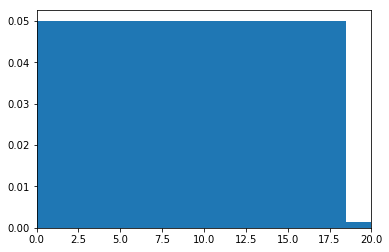

18.8285350429
2.67324094908


In [32]:
chi = copy.copy(chi2)
chi = np.array(chi)
#chi = chi[chi<20]
plt.hist(chi,1000,normed=True)
plt.xlim([0,20])
plt.show()
print(np.mean(chi))
print(np.median(chi))


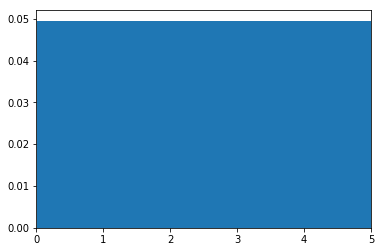

32.166830233577336
2.174751906465619
0.8739706239306625


In [457]:
chi = copy.copy(chi2)
chi = np.array(chi)
#chi = chi[chi<20]
plt.hist(chi,1000,normed=True)
plt.xlim([0,5])
plt.show()
print(np.mean(chi))
print(np.median(chi))

n = 0
for i in range(len(chi)):
    if(chi[i] <= 10):
        n = n +1
        
print(n/len(chi))

In [33]:
newBands = []
newErrors = []
for i in range(len(br_Gmag)):
    starBand = all_BrightStars[i]
    starBand = np.array(starBand)
    starBand = starBand[~np.isnan(starBand)]
    starError = star_err_br[i]
    starError = starError[~np.isnan(starError)]
    if(len(starBand) == len(all_BrightStars[i]) and len(starError) == len(star_err_br[i])):
        newBands.append(starBand)
        newErrors.append(starError)
newBands = np.array(newBands)
newErrors = np.array(newErrors)
print(len(newBands),len(chi))    
betterBands = []
betterErrors = []
for i in range(len(chi)):
    if(chi[i] <= 10.0):
        betterBands.append(newBands[i])
        betterErrors.append(newErrors[i])
        
betterBands = np.array(betterBands)
betterErrors = np.array(betterErrors)
        

168913 168913


In [34]:
colors = np.arange(-0.45,3,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS/TEMPLATES

# BRIGHT STARS
best_color_br = ColorClassification(betterBands[:,0],betterBands[:,5],colors)

best_stars_br,best_color_mags_br,best_color_std_br,best_color_std_err_br,best_abs_color_mags_br,best_abs_color_std_br,\
best_abs_color_std_err_br = \
CreateTemplates(best_color_br,colors,Gmags=betterBands[:,0],Kmags=betterBands[:,5],GB_mags=betterBands[:,1],\
                GR_mags=betterBands[:,2],J_mags=betterBands[:,3],H_mags=betterBands[:,4])



/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


In [35]:
betterStars = np.transpose([betterBands[:,0],betterBands[:,1],betterBands[:,2],betterBands[:,3],betterBands[:,4],\
                            betterBands[:,5]])

print(betterStars[0])

[ 10.02853012  10.37783909   9.54774475   8.99300003   8.68599987
   8.65100002]


In [49]:
stars_dm

array([   0.,   19.,   34.,   40.,   32.,   38.,   39.,   27.,   27.,
         43.,   36.,   38.,   33.,   39.,   43.,   43.,   33.,   49.,
         43.,   40.,   29.,   54.,   40.,   47.,   38.,   41.,   44.,
         43.,   39.,   42.,   36.,   28.,   27.,   40.,   31.,   39.,
         33.,   21.,   39.,   38.,   45.,   26.,   37.,   45.,   44.,
         39.,   28.,   49.,   40.,   25.,   38.,   25.,   41.,   31.,
         26.,   38.,   40.,   41.,   58.,   49.,   56.,   48.,   59.,
         59.,   71.,   95.,   95.,   98.,   98.,  128.,  136.,  152.,
        158.,  158.,  198.,  222.,  230.,  233.,  276.,  280.,  290.,
        288.,  308.,  332.,  337.,  360.,  377.,  409.,  405.,  437.,
        484.,  448.,  493.,  481.,  510.,  485.,  541.,  590.,  571.,
        538.,  618.,  613.,  649.,  695.,  716.,  706.,  726.,  771.,
        784.,  754.,  845.,  857.,  891.,  857.,  847.,  915.])


Reduced X^2 for Bright Template Fit: 2.13824067083
Reduced X^2 for Faint Template Fit: 2082.06147045


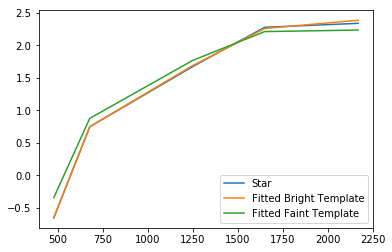

[   2.13824067    6.29304503    7.02107211   20.24199668   21.17196536
   43.7443578    44.32075832   72.65979253   75.57092137  112.53302158
  119.99793714]


In [98]:
#print(color_mags_br[0])
mags = copy.copy(best_color_mags_br)
mags = mags[1:len(best_color_mags_br)]
#mags = mags[55:len(mags)]
mags_dm = copy.copy(color_mags_dm)
mags_dm = mags_dm[1:len(mags_dm)]

#star_err = np.transpose([G_unc_br,GB_unc_br,GR_unc_br,J_unc_br,H_unc_br,K_unc_br])
idx = np.random.randint(1,len(betterBands[:,0]))
starBand = betterStars[idx]
starBand = np.array(starBand)
starBand = starBand[~np.isnan(starBand)]
starError = betterErrors[idx]
starError = starError[~np.isnan(starError)]
#print(starError)
if(len(starBand) == len(betterErrors[idx]) and len(starError) == len(star_err[idx])):
    
    fit, newBands, newStar_err, chi2, chi2_vals1 = StarFit(starBand,mags,starError)
    fit2, newBands, newStar_err2, chi2_2, chi2_vals2 = StarFit(starBand,mags_dm,starError)
#print(newStar_err)
wvl = [477,677,1250,1650,2170]
print('\nReduced X^2 for Bright Template Fit:', chi2)
print('Reduced X^2 for Faint Template Fit:', chi2_2)
mag2 = copy.copy(mags[fit])
mag2 = mag2[~np.isnan(mag2)]
mag3 = copy.copy(mags_dm[fit2])
mag3 = mag3[~np.isnan(mag3)]
plt.plot(wvl,newBands,label='Star')
plt.plot(wvl,mag2,label='Fitted Bright Template')
plt.plot(wvl,mag3,label='Fitted Faint Template')
plt.legend()
plt.show()

t = Table()
first10Chi2 = []
while(len(first10Chi2) <= 10):
    for i in range(len(chi2_vals1)):
        if(chi2_vals1[i] == np.nanmin(chi2_vals1)):
            ID = i
            first10Chi2.append(chi2_vals1[i])
    chi2_vals1[ID] = np.nan
        
#print('Reduced X^2 Value for StarFitting:', chi2)
first10Chi2 = np.array(first10Chi2)
t['1'] = first10Chi2
print(first10Chi2)

In [67]:
mags_br = copy.copy(best_color_mags_br)
mags_br = mags_br[1:len(mags_br)]

betterChi2 = []
G_GBcolor = []
G_GRcolor = []
GJcolor = []
GKcolor = []
GHcolor = []


for i in range(len(betterStars)):
    starBand = betterStars[i]
    starBand = np.array(starBand)
    starBand = starBand[~np.isnan(starBand)]
    starError = betterErrors[i]
    starError = starError[~np.isnan(starError)]
    if(len(starBand) == len(betterStars[i]) and len(starError) == len(betterErrors[i])):
        fit_br, newBands, newStar_err, chi2_br, array1 = StarFit(starBand,mags_br,starError)
        betterChi2.append(chi2_br)
        G_GBcolor.append(mags_br[fit_br,2])
        G_GRcolor.append(mags_br[fit_br,5])
        GJcolor.append(mags_br[fit_br,7])
        GHcolor.append(mags_br[fit_br,8])
        GKcolor.append(mags_br[fit_br,9])
        
        
betterChi2 = np.array(betterChi2)  
G_GBcolor = np.array(G_GBcolor)
G_GRcolor = np.array(G_GRcolor)
GJcolor = np.array(GJcolor)
GHcolor = np.array(GHcolor)
GKcolor = np.array(GKcolor)

In [100]:
print(len(all_dimStars),len(G_unc_dm))

25988 25988


In [101]:
star_err_dm = np.transpose([G_unc_dm,GB_unc_dm,GR_unc_dm,J_unc_dm,H_unc_dm,K_unc_dm])

mags_br = copy.copy(best_color_mags_br)
mags_br = mags_br[1:len(mags_br)]

betterChi2_dm = []
G_GBcolor_dm = []
G_GRcolor_dm = []
GJcolor_dm = []
GKcolor_dm = []
GHcolor_dm = []


for i in range(len(all_dimStars)):
    starBand = all_dimStars[i]
    starBand = np.array(starBand)
    starBand = starBand[~np.isnan(starBand)]
    starError = star_err_dm[i]
    starError = starError[~np.isnan(starError)]
    if(len(starBand) == len(all_dimStars[i]) and len(starError) == len(star_err_dm[i])):
        fit_br, newBands, newStar_err, chi2_br, array1 = StarFit(starBand,mags_br,starError)
        betterChi2_dm.append(chi2_br)
        G_GBcolor_dm.append(mags_br[fit_br,2])
        G_GRcolor_dm.append(mags_br[fit_br,5])
        GJcolor_dm.append(mags_br[fit_br,7])
        GHcolor_dm.append(mags_br[fit_br,8])
        GKcolor_dm.append(mags_br[fit_br,9])
        
        
betterChi2_dm = np.array(betterChi2_dm)  
G_GBcolor_dm = np.array(G_GBcolor_dm)
G_GRcolor_dm = np.array(G_GRcolor_dm)
GJcolor_dm = np.array(GJcolor_dm)
GHcolor_dm = np.array(GHcolor_dm)
GKcolor_dm = np.array(GKcolor_dm)

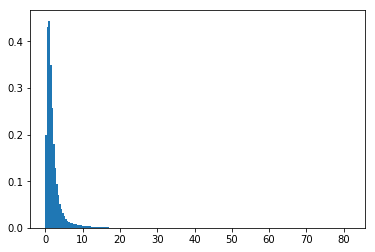

Mean Reduced Chi Squared: 2.02735299217
Medium Reduced Chi Squared: 1.39415392836


In [117]:
plt.hist(betterChi2,200,normed=True)
#plt.xlim([0,15])
plt.show()
print('Mean Reduced Chi Squared:', np.mean(betterChi2))
print('Medium Reduced Chi Squared:', np.median(betterChi2))


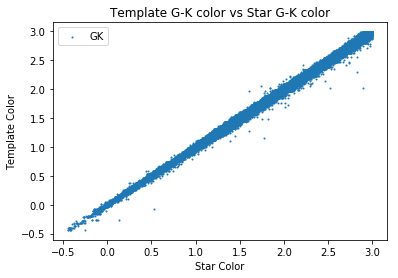

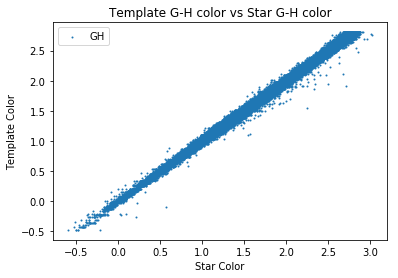

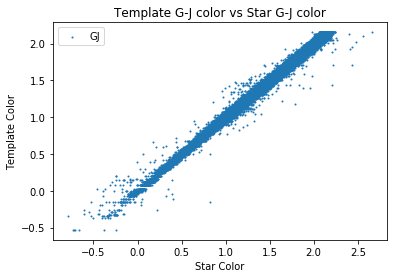

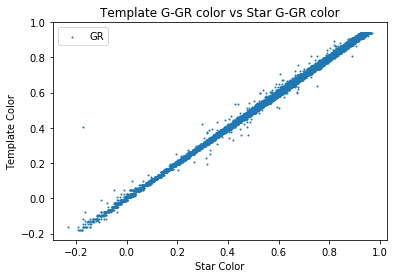

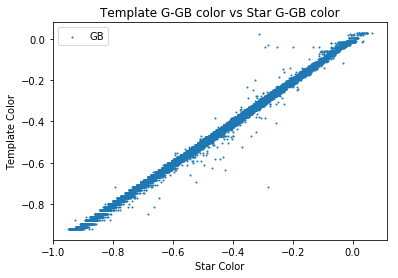

In [71]:
goodGB = np.array(betterStars[:,0] - betterStars[:,1])
goodGR = np.array(betterStars[:,0] - betterStars[:,2])
goodGJ = np.array(betterStars[:,0] - betterStars[:,3])
goodGH = np.array(betterStars[:,0] - betterStars[:,4])
goodGK = np.array(betterStars[:,0] - betterStars[:,5])

plt.scatter(goodGK,GKcolor,label='GK',s=1.0)
plt.legend()
plt.title('Template G-K color vs Star G-K color')
plt.xlabel('Star Color')
plt.ylabel('Template Color')
plt.show()

plt.scatter(goodGH,GHcolor,label='GH',s=1.0)
plt.legend()
plt.title('Template G-H color vs Star G-H color')
plt.xlabel('Star Color')
plt.ylabel('Template Color')
plt.show()

plt.scatter(goodGJ,GJcolor,label='GJ',s=1.0)
plt.legend()
plt.title('Template G-J color vs Star G-J color')
plt.xlabel('Star Color')
plt.ylabel('Template Color')
plt.show()

plt.scatter(goodGR,G_GRcolor,label='GR',s=1.0)
plt.legend()
plt.title('Template G-GR color vs Star G-GR color')
plt.xlabel('Star Color')
plt.ylabel('Template Color')
plt.show()

plt.scatter(goodGB,G_GBcolor,label='GB',s=1.0)
plt.legend()
plt.title('Template G-GB color vs Star G-GB color')
plt.xlabel('Star Color')
plt.ylabel('Template Color')
plt.show()

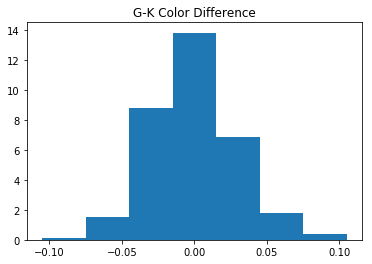

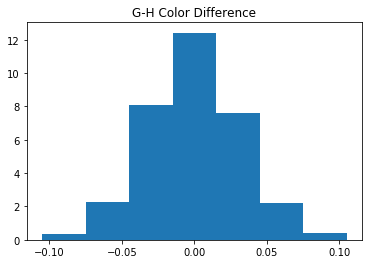

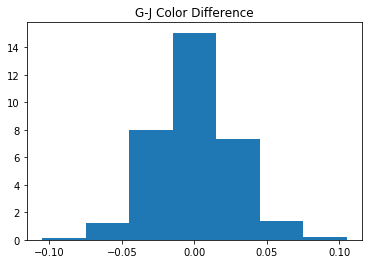

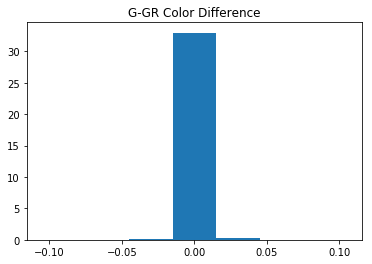

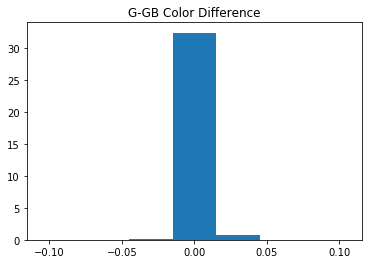

In [86]:
bins = [-0.105,-0.075,-0.045,-0.015,0.015,0.045,0.075,0.105]

GKdiff = goodGK - GKcolor
plt.hist(GKdiff,bins=bins,normed=True)
plt.title('G-K Color Difference')
#plt.xlim([-0.1,0.1])
plt.show()

GHdiff = goodGH - GHcolor
plt.hist(GHdiff,bins=bins,normed=True)
plt.title('G-H Color Difference')
#plt.xlim([-0.1,0.1])
plt.show()

GJdiff = goodGJ - GJcolor
plt.hist(GJdiff,bins=bins,normed=True)
plt.title('G-J Color Difference')
#plt.xlim([-0.1,0.1])
plt.show()

G_GRdiff = goodGR - G_GRcolor
plt.hist(G_GRdiff,bins=bins,normed=True)
plt.title('G-GR Color Difference')
#plt.xlim([-0.1,0.1])
plt.show()

G_GBdiff = goodGB - G_GBcolor
plt.hist(G_GBdiff,bins=bins,normed=True)
plt.title('G-GB Color Difference')
#plt.xlim([-0.1,0.1])
plt.show()

In [112]:
print(len(GK_dm),len(GKcolor_dm))

25855 15368


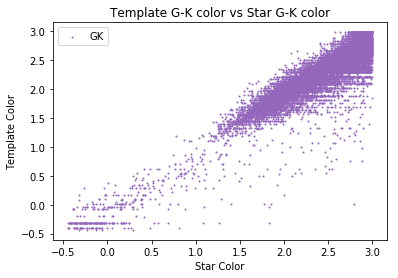

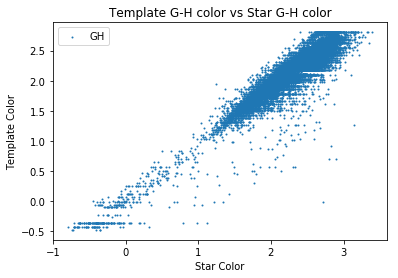

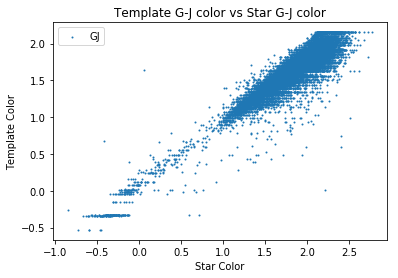

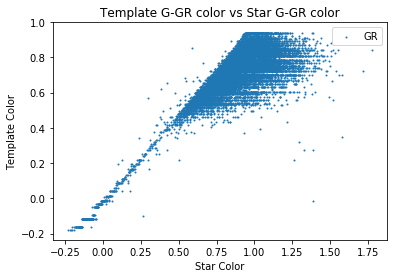

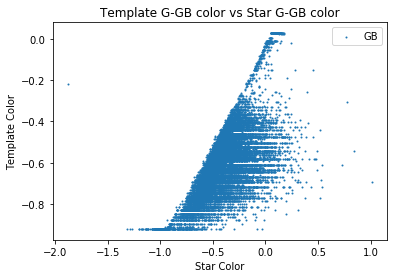

In [113]:
GB_dm = []
GR_dm = []
GJ_dm = []
GH_dm = []
GK_dm = []

for i in range(len(all_dimStars)):
    starBand = all_dimStars[i]
    starBand = starBand[~np.isnan(starBand)]
    starError = star_err_dm[i]
    starError = starError[~np.isnan(starError)]
    if(len(starBand) == len(all_dimStars[i]) and len(starError) == len(star_err_dm[i])):
        GB_dm.append(starBand[0] - starBand[1])
        GR_dm.append(starBand[0] - starBand[2])
        GJ_dm.append(starBand[0] - starBand[3])
        GH_dm.append(starBand[0] - starBand[4])
        GK_dm.append(starBand[0] - starBand[5])

plt.scatter(GK_dm,GKcolor_dm,label='GK',s=1.0)
plt.legend()
plt.title('Template G-K color vs Star G-K color')
plt.xlabel('Star Color')
plt.ylabel('Template Color')
plt.show()

plt.scatter(GH_dm,GHcolor_dm,label='GH',s=1.0)
plt.legend()
plt.title('Template G-H color vs Star G-H color')
plt.xlabel('Star Color')
plt.ylabel('Template Color')
plt.show()

plt.scatter(GJ_dm,GJcolor_dm,label='GJ',s=1.0)
plt.legend()
plt.title('Template G-J color vs Star G-J color')
plt.xlabel('Star Color')
plt.ylabel('Template Color')
plt.show()

plt.scatter(GR_dm,G_GRcolor_dm,label='GR',s=1.0)
plt.legend()
plt.title('Template G-GR color vs Star G-GR color')
plt.xlabel('Star Color')
plt.ylabel('Template Color')
plt.show()

plt.scatter(GB_dm,G_GBcolor_dm,label='GB',s=1.0)
plt.legend()
plt.title('Template G-GB color vs Star G-GB color')
plt.xlabel('Star Color')
plt.ylabel('Template Color')
plt.show()

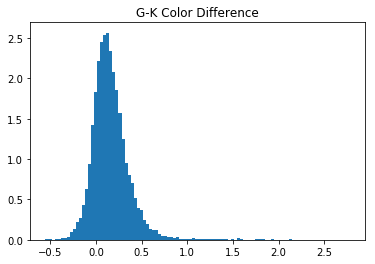

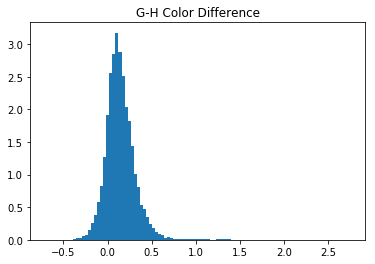

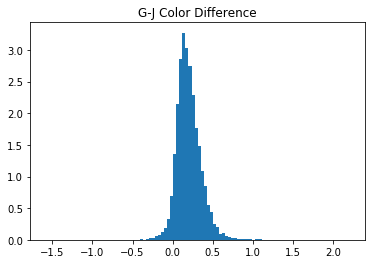

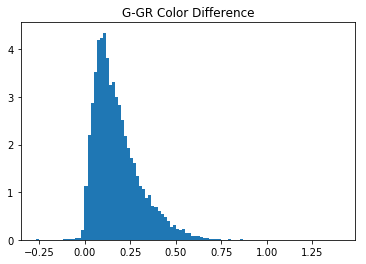

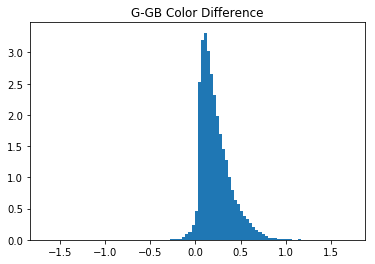

In [115]:
#bins = [-0.105,-0.075,-0.045,-0.015,0.015,0.045,0.075,0.105]
bins = 100
GKdiff = GK_dm - GKcolor_dm
plt.hist(GKdiff,bins=bins,normed=True)
plt.title('G-K Color Difference')
#plt.xlim([-0.1,0.1])
plt.show()

GHdiff = GH_dm - GHcolor_dm
plt.hist(GHdiff,bins=bins,normed=True)
plt.title('G-H Color Difference')
#plt.xlim([-0.1,0.1])
plt.show()

GJdiff = GJ_dm - GJcolor_dm
plt.hist(GJdiff,bins=bins,normed=True)
plt.title('G-J Color Difference')
#plt.xlim([-0.1,0.1])
plt.show()

G_GRdiff = GR_dm - G_GRcolor_dm
plt.hist(G_GRdiff,bins=bins,normed=True)
plt.title('G-GR Color Difference')
#plt.xlim([-0.1,0.1])
plt.show()

G_GBdiff = GB_dm - G_GBcolor_dm
plt.hist(G_GBdiff,bins=bins,normed=True)
plt.title('G-GB Color Difference')
#plt.xlim([-0.1,0.1])
plt.show()

In [920]:
# FITTING FAINT STARS TO FAINT AND BRIGHT TEMPLATES USING ACTUAL STAR UNCERTAINTY

star_err_dm = np.transpose([G_unc_dm,GB_unc_dm,GR_unc_dm,J_unc_dm,H_unc_dm,K_unc_dm])
mags_br = copy.copy(color_mags_br)
mags_br = mags[1:len(mags_br)]
mags_dm = copy.copy(color_mags_dm)
mags_dm = mags_dm[1:len(mags_dm)]
chi2_Faint = []
BrightTempFits = 0
FaintTempFits = 0
for i in range(len(dm_Gmag)):
    starBand = all_dimStars[i]
    starBand = np.array(starBand)
    starBand = starBand[~np.isnan(starBand)]
    starError = star_err_dm[i]
    starError = starError[~np.isnan(starError)]
    if(len(starBand) == len(all_dimStars[i]) and len(starError) == len(star_err_dm[i])):
        fit_br, newBands, newStar_err, chi2_br, array1 = StarFit(starBand,mags_br,starError)
        fit_dm, newBands, newStar_err, chi2_dm, array2 = StarFit(starBand,mags_dm,starError)
        chi2_Faint.append(chi2_dm)
        if(chi2_br < chi2_dm):
            BrightTempFits = BrightTempFits + 1
        if(chi2_dm < chi2_br):
            FaintTempFits = FaintTempFits + 1
chi2_Faint = np.array(chi2_Faint)            
print('Percentage of Fits On to Bright Templates: ' + str(100*(BrightTempFits/len(all_dimStars))))
print('Percentage of Fits On to Faint Templates: ' + str(100*(FaintTempFits/len(all_dimStars))))

Percentage of Fits On to Bright Templates: 47.96156842378603
Percentage of Fits On to Faint Templates: 36.69244284668849


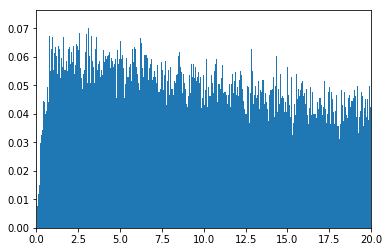

9.501527623030883
9.176084330409005


In [933]:
chi_fa = copy.copy(chi2_Faint)
chi_fa = np.array(chi_fa)
chi_fa = chi_fa[chi_fa<20]
plt.hist(chi_fa,1000,normed=True)
#plt.hist(1000,normed=True)
plt.xlim([0,20])
plt.show()
print(np.mean(chi_fa))
print(np.median(chi_fa))

In [1070]:
star_err_br = np.transpose([G_unc_br,GB_unc_br,GR_unc_br,J_unc_br,H_unc_br,K_unc_br])
mags_br = copy.copy(color_mags_br)
mags_br = mags[1:len(mags_br)]
mags_dm = copy.copy(color_mags_dm)
mags_dm = mags_dm[1:len(mags_dm)]

BrightTempFits = 0
FaintTempFits = 0
indexes = np.arange(1,len(Gmag))
t = Table()
for i in range(100):
    starBand = all_BrightStars[i]
    starBand = np.array(starBand)
    starBand = starBand[~np.isnan(starBand)]
    starError = star_err_br[i]
    starError = starError[~np.isnan(starError)]
    if(len(starBand) == len(all_BrightStars[i]) and len(starError) == len(star_err_br[i])):
        fit_br, newBands, newStar_err, chi2_br, chi2_vals1 = StarFit(starBand,mags_br,starError)
        
    first10Chi2 = []
    while(len(first10Chi2) <= 10):
        for i in range(len(chi2_vals1)):
            if(chi2_vals1[i] == np.nanmin(chi2_vals1)):
                ID = i
                first10Chi2.append(chi2_vals1[i])
        chi2_vals1[ID] = np.nan
    t[str(indexes[i])] = first10Chi2
    #print('Reduced X^2 Value for StarFitting:', chi2)
    first10Chi2 = np.array(first10Chi2)

In [1091]:
b = Table()
v = str(np.array([1,2,3,4]))
b[v[0]] = Column([1,2])
print(b)

 [ 
---
  1
  2


In [1089]:
from astropy.table import Table, Column

t = Table()
t['Value 1'] = [1, 4, 5]
t['Value 2'] = Column([2.0, 5.0, 5], unit='cm', description='Velocity')
t['Value 3'] = ['x', 'y', 'c']
t[str(c[2])] = [1, 4, 6]
print(t)

c = np.arange(1,4,1)
print(c)

Value 1 Value 2 Value 3  3 
           cm              
------- ------- ------- ---
      1     2.0       x   1
      4     5.0       y   4
      5     5.0       c   6
[1 2 3]
